# Climate Risk Analysis: Chad Drought and Extreme Rainfall Analysis 2011

## Introduction

Chad is a landlocked country in Central Africa that faces significant climate related challenges due to its semi arid climate. The countrty experience severe rainfall variability, going from a large portion of the year of minimal rainfall in a vast majority of the country to heavy intense rainfall during the country's wet season. Both of these weather events pose a serious risk to agriculture, infrastructure, and livelihoods in the country.

This notebook analyses the climate extremes in Chad during 2011, a particularly significant year as was in the centre of a sequence of severe drought across multiple years both locally and in the wider region.

**Objectives**
- Show drought and extreme rainfall in Chad during 2011
- Compare local and national patterns
- Identify spatial and temporal variations of climate risk
- Compare in relation to historical basis as to show the extremeness 

## Data Sources

### Primary Data Used: CHIRPS 2011 Global Precipitation Dataset
- **Spatial Resolution**: 0.25 x 0.25 resolution (approximately 25km)
- **Temporal Resolution**: Daily
- **Coverage**: Global year of 2011
- **Variables**: Daily precipitation
- **Source**: netCDF file https://data.chc.ucsb.edu/products/CHIRPS-2.0/

### Supplementary Data
**Country Boundaries**:
- Source: Natural Earth (110m cultural vectors)
- URL: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
- Purpose: Spatial clipping and visualization

**Historical Data**: CHIRPS Precipitation dataset
**Spatial Resolution**: 0.25 x 0.25 resolution (approximately 25km)
- **Temporal Resolution**: Daily
- **Coverage**: 1981-2009
- **Variables**: Daily precipitation
- **Source**: netCDF file https://data.chc.ucsb.edu/products/CHIRPS-2.0/

### Data Processing Notes:
- CHIRPS data were subset to Chad's bounding box (7°N-24°N, 14°E-24°E)
- N'Djamena coordinates: 12.125°N, 15.125°E (nearest grid cell)
- Missing data: CHIRPS has complete global coverage; no missing values
- Units: All precipitation values in millimeters (mm)
- For the historical data, I am taking a 30 year (accepted climatology reference) period prior to the date of analysis.
- Due to the nature of CHIRPS data, I will be individually loading in each year from 1981-2009.
- I did not include 2010, as well it would be closer to the 30 year accepted period, it was a severe drought year and is part of the reason for the 2011 year selection.

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import geopandas as gpd
import geodatasets as gd
import rioxarray
import requests
from config import get_raw_dir, get_event_dir
from shutil import copy2

chirps_url = "https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p25/"
COUNTRY = "chad"
DATASET = "chirps"
YEARS = list(range(1981, 2010)) + [2011]
BASELINE_YEARS = list(range(1981, 2010)) 
PRIMARY_YEARS = [2011]

raw_dir = get_raw_dir(COUNTRY, DATASET)
baseline_dir = get_event_dir(COUNTRY, DATASET, "baseline")
primary_dir = get_event_dir(COUNTRY, DATASET, "primaryevent")

all_exists = True
for year in YEARS:
    filename = f"chirps-v2.0.{year}.days_p25.nc" 
    filepath = raw_dir / filename

    if filepath.exists():
        continue

    print(f"Downloading {filename}...")
    r = requests.get(chirps_url + filename, stream=True)
    r.raise_for_status()
    with open(filepath, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

if all_exists == True:
    print("All files are already installed")  

files = sorted(baseline_dir.glob("chirps-v2.0.*.days_p25.nc"))

for year in range(1981, 2010):
    src = raw_dir / f"chirps-v2.0.{year}.days_p25.nc"
    dst = baseline_dir / src.name

    if not dst.exists():
        copy2(src, dst)
for year in PRIMARY_YEARS:
    src = raw_dir / f"chirps-v2.0.{year}.days_p25.nc"
    dst = primary_dir / src.name

    if not dst.exists():
        copy2(src, dst)

ds = xr.open_dataset(primary_dir / "chirps-v2.0.2011.days_p25.nc")

lat_min, lat_max = 7.0, 24.0
long_min, long_max = 14.0, 24.0

url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
chad_shape = world[world["NAME"] == "Chad"]

All files are already installed


## Historical Analysis

To discover and show how 2011 and the period surrounding it was an especially anomalous period for Chad, I am going to compare it to a 29 year period historical baseline between 1981-2009, just before the major drought of 2010.

### Why 1981-2009?
**Standard period**: 30 years is the standard WHO climatology period.    
**Pre Drought Baseline**: 1981-2009 is before the major drought of 2010, thus allowing an unbiased view at chad before the major drought.  
**Data**: Due to using CHIRPS datasets throughout this data, the first available back year is 1981.

### Statistical References
**Climatalogical mean annual rainfall**: The mean annual rainfall 1981-2009 in Chad.  
**Interannual rainfall variability**: Shows how unusual the 2010-2012 period was.  
**Area averaged rainfall time series graph**: Showing the natural variability of Chad and possible trends lending to the disaster of 2010-12.  
**Frequency of dry years and deficits**: Showing how frequent lower percentile years of rainfall are.  
**Distribution of rainfall total**: A backdrop to show how low rainfall was in Chad during the drought period.  


In [2]:
ds30 = xr.open_mfdataset(
    files,
    combine="by_coords",
    parallel=True
)

chad_hist = ds30.sel(
    latitude = slice(lat_min, lat_max),
    longitude = slice(long_min, long_max)
)

hist_mean = chad_hist["precip"].mean(dim=["latitude", "longitude"])
annual = hist_mean.groupby("time.year").sum("time")
hist_antotal = (hist_mean.groupby("time.year").sum("time").to_dataframe(name="annual_rainfall_mm").reset_index())

### Climatological mean annual rainfall

 Climatological mean annual rainfall represents the expected annual rainfall of Chad over the 1981-2009 period. These values serve as a baseline of rainfall in a non drought period to show and to reference off of to show anomalous years, such as 2011.


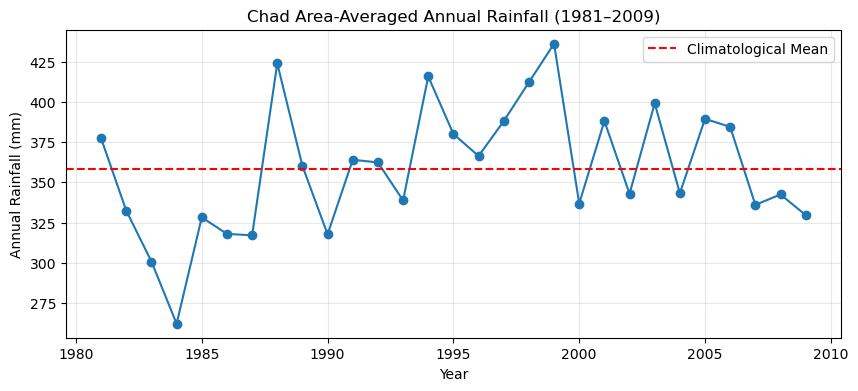

In [3]:
clim_mean = annual.mean().compute().item()
clim_std = annual.std().compute().item()

dataframe_meanann = annual.compute().to_dataframe(name="annual_rainfall_mm").reset_index()

plt.figure(figsize=(10,4))
plt.plot(dataframe_meanann["year"], dataframe_meanann["annual_rainfall_mm"], marker="o")
plt.axhline(clim_mean, color="red", linestyle="--", label="Climatological Mean")
plt.xlabel("Year")
plt.ylabel("Annual Rainfall (mm)")
plt.title("Chad Area-Averaged Annual Rainfall (1981–2009)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Interpretation

During the 1981-2009 Period, Chad received a mean average annual rainfall of approximately 359mm of rainfall with a standard deviation of 39. This indicated moderate yearly variability in nationally average rainfall, showing the influence of a combined highly arid north and a fairly humid southern third. This baseline is important for providing the context behind the severity of drought and lack of rainfall during both the dry and wet season in the 2010-12 period and most significantly 2011.

### Interannual rainfall variability and anomalies

This section examines the the yearly variability in Chads annual rainfall during the baseline period of 1981-2009. Rainfall anomalies and standardised z scores are calculated relative to the climatological mean in order to quantify how abnormal an individual year was within historical context.  

Coefficient of Variation: 10.95%


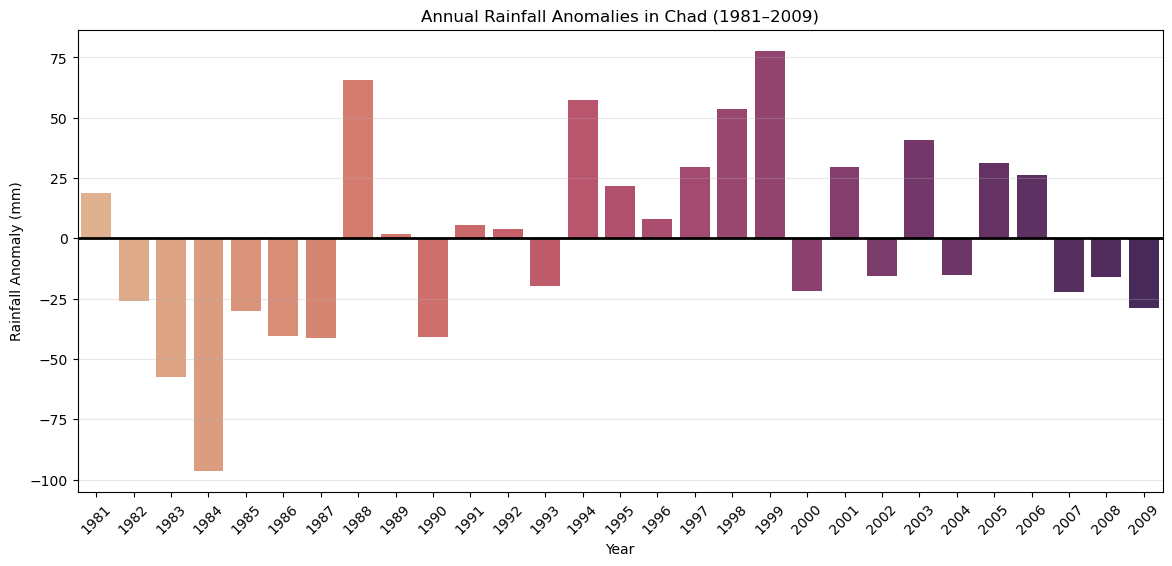

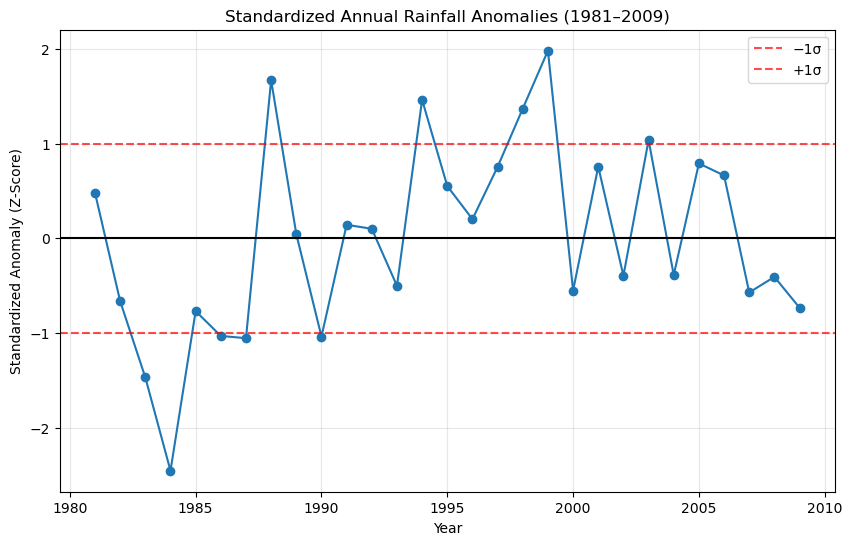

In [4]:
annual_anom = annual - clim_mean
annual_z = annual_anom / clim_std
cv = clim_std / clim_mean

print(f"Coefficient of Variation: {cv:.2%}")

dataframe_itann = (
    xr.Dataset({
        "annual_rainfall_mm": annual,
        "anomaly_mm": annual_anom,
        "z_score": annual_z
    }).compute().to_dataframe().reset_index()
)

plt.figure(figsize=(14,6))
sns.barplot(
    data=dataframe_itann,
    x="year",
    y="anomaly_mm",
    palette="flare",
    legend=False,
    hue="year"
)
plt.axhline(0, color="black", linewidth=2)
plt.xlabel("Year")
plt.ylabel("Rainfall Anomaly (mm)")
plt.title("Annual Rainfall Anomalies in Chad (1981–2009)")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(
    dataframe_itann["year"],
    dataframe_itann["z_score"],
    marker="o",
    linewidth=1.5
)
plt.axhline(0, color="black")
plt.axhline(-1, color="red", linestyle="--", alpha=0.7, label="−1σ")
plt.axhline(1, color="red", linestyle="--", alpha=0.7, label="+1σ")
plt.xlabel("Year")
plt.ylabel("Standardized Anomaly (Z‑Score)")
plt.title("Standardized Annual Rainfall Anomalies (1981–2009)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


#### Interpretation

Rainfall during the 1981–2009 baseline period exhibits substantial interannual variability, with the majority of years falling within ±1 standard deviation of the climatological mean. This indicates that, while yearly fluctuations are common, extreme deviations from normal conditions were relatively infrequent during the period. A large exception occurs during the early 1980s, where pronounced negative standardized anomalies indicate a period of severe drought, particularly during 1983–84.

Overall, the standardized anomaly analysis suggests that dry years were recurrent but typically moderate in magnitude, with rainfall conditions often returning toward norms in subsequent years. This behavior provides a stable baseline against which conditions leading up to, and including, 2011 can be evaluated to determine whether that year represented a departure from long‑term variability or a continuation of trends.

**Note**: While not explored within this notebook, 1983-84 is showing as a serious anomaly not due to an error in my work but due to it being historically documented drought conditions in Chad and the Sahel region, which resulted in widespread crop failures and food insecurity. While a detailed exploration of these events is beyond the scope of this notebook, and deserving of multiple on its own, I am acknowledging it here to provide important historical context. 

For some further reading on the improvement in climate assessment and risk in the Sahel:
https://reliefweb.int/report/burkina-faso/west-africa-sahels-nutrition-revolution

### Frequency of dry years and deficits analysis

To further show historical drought risk in Chad, this section examines the frequency of dry years during the baseline period of 1981-2009. Dry years are determined via a percentile threshold, derived from the historical distribution of annual rainfall totals. This method will demonstrate how common a year with low rainfall, thus a dry year, occurred before the year of analysis.

For this analysis the percentile thresholds will be defined as so:

**20th percentile**: A dry year  
**10th percentile**: A potential drought year

This is accommodating for the fact that Chad is a semi arid climate and that the interest is not only in potential drought, being 10th percentile, but also what is considered a dry year so that we can start to see potential patterns in a downwards trend of rainfall.

For the histogram, sturges method is applied here **`sg_dry`** to calculate the bins, as the dataset is quite small (29 values).

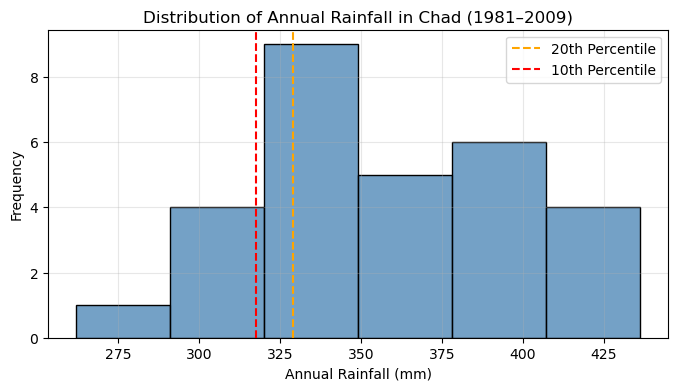

,year,annual_rainfall_mm,z_score
2,1983,300.767853,-1.469449
3,1984,262.124329,-2.454376
4,1985,328.258698,-0.768777
5,1986,317.979370,-1.030771
6,1987,317.064423,-1.054091
9,1990,317.705719,-1.037746


In [5]:
p20 = annual.quantile(0.20).compute().item()
p10 = annual.quantile(0.10).compute().item()

sg_dry = int(np.ceil(np.log2(29) + 1))

dataframe_itann["dry_20"] = dataframe_itann["annual_rainfall_mm"] <= p20
dataframe_itann["dry_10"] = dataframe_itann["annual_rainfall_mm"] <= p10

dry_count20 = dataframe_itann["dry_20"].sum()
dry_count10 = dataframe_itann["dry_10"].sum()
total_year = len(dataframe_itann)

plt.figure(figsize=(8,4))
sns.histplot(
    dataframe_itann["annual_rainfall_mm"],
    bins=sg_dry,
    color="steelblue"
)
plt.axvline(p20, color="orange", linestyle="--", label="20th Percentile")
plt.axvline(p10, color="red", linestyle="--", label="10th Percentile")
plt.xlabel("Annual Rainfall (mm)")
plt.ylabel("Frequency")
plt.title("Distribution of Annual Rainfall in Chad (1981–2009)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

dataframe_itann.loc[dataframe_itann["dry_20"], ["year", "annual_rainfall_mm", "z_score"]]

#### Interpretation

Using percentile based threshold, 6 of the years in the 1981-2009 period can be considered dry years, falling under the 20th percentile of annual rainfall. 30% of these years are falling below the 10th percentile, being a small subset of the overall data at 7%. This indicates that while yes, below average rainfall does occur with some regularity during the baseline period, extreme drought was a relatively rare occurence. These percentile thresholds show a useful framework for how rainfall deficits were observed between 1981-2009, and also how it relates towards the downturn in 2010 and how this affected the analysed year of 2011.

### Distribution of Annual Rainfall totals

This section is going to examine the distribution of area averaged annual rainfall totals in Chad during the baseline period of 1981-2009. The historical distribution provides a probablistic demonstration against which the rainfall conditions during 2011 can be contextualised.

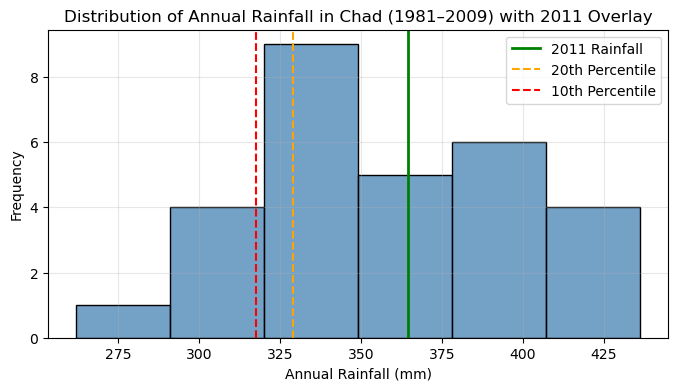

In [6]:
chad = ds.sel(
    latitude = slice(lat_min, lat_max),
    longitude = slice(long_min, long_max)
)

mean_2011 = chad["precip"].mean(dim=["latitude", "longitude"])
total_2011 = mean_2011.sum("time").compute().item()

plt.figure(figsize=(8, 4))
sns.histplot(
    dataframe_itann["annual_rainfall_mm"],
    bins=sg_dry,
    color="steelblue",
    edgecolor="black"
)

plt.axvline(
    total_2011,
    color="green",
    linewidth=2,
    label="2011 Rainfall"
)
plt.axvline(p20, color="orange", linestyle="--", label="20th Percentile")
plt.axvline(p10, color="red", linestyle="--", label="10th Percentile")
plt.xlabel("Annual Rainfall (mm)")
plt.ylabel("Frequency")
plt.title("Distribution of Annual Rainfall in Chad (1981–2009) with 2011 Overlay")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Interpretation

The analysis of the distribution of rainfall across Chad highlights that despite the fact that 2011 was frought with food shortage and agricultural damage, the nationally calculated annual rainfall for the year was well above the 20th percentile, being in a reasonably average position and falling in line with the historical baseline set. This indicates that the severity of the 2011 crisis and the problems associated with it cannot be fully explained with total annual rainfall alone, highlighting the importance of spatial variability and multi year impacts to an event.

#### Analysing further, the wet season and Sahel

The analysis of national, area averaged annual rainfall indicates that total rainfall in 2011 falls within the historical range observed during the 1981–2009 baseline. This suggests that total annual rainfall alone may not fully capture the drivers of the 2011 crisis in Chad. In particular, the impacts of drought may be masked by strong regional variability across the country or driven by changes in rainfall timing rather than annual totals.

To investigate this further, the following analyses refine the temporal and spatial scale of the assessment. First, rainfall during Chad’s primary wet season (June to September) is examined, as this period is critical for rain fed agriculture. Second, the analysis is restricted to the Sahelian region of Chad, which was disproportionately affected during the 2010–2012 drought period. Together, these approaches aim to determine whether the drought signal evident in 2011 emerges more clearly when seasonal and regional factors are explicitly considered.

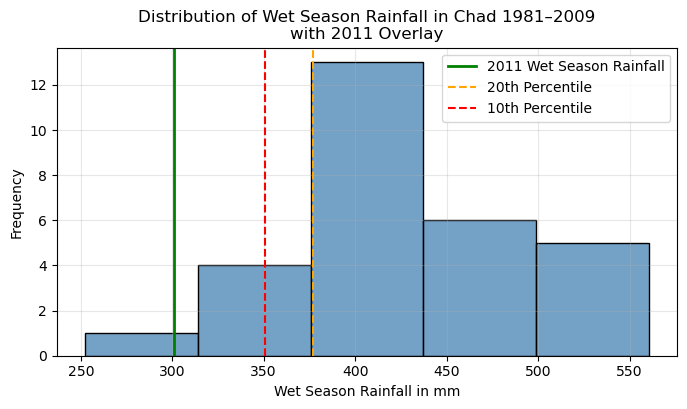

In [7]:
rainy_season = chad.sel(time=chad["time.month"].isin([6,7,8,9]))
wetsn_mean = rainy_season["precip"].mean(dim=["latitude","longitude"]).sum("time")

chad_sahel = chad_hist.sel(latitude=slice(10, 16))

sahel = (chad_sahel["precip"].mean(dim=["latitude","longitude"]).groupby("time.year").sum("time"))

wet_mean = sahel.mean().compute().item()
wet_std = sahel.std().compute().item()

wet_z_2011 = (wetsn_mean.compute().item() - wet_mean) / wet_std
wet_percentile_2011 = (sahel < wetsn_mean).mean().compute().item() * 100

dataframe_wetsn = (sahel.compute().to_dataframe(name="wetsn_rainfall_mm").reset_index())
wetsn_2011 = wetsn_mean.compute().item()

wp20 = sahel.quantile(0.20).compute().item()
wp10 = sahel.quantile(0.10).compute().item()

sg_wet = int(np.ceil(np.log2(len(dataframe_wetsn) + 1)))

plt.figure(figsize=(8,4))
sns.histplot(
    dataframe_wetsn["wetsn_rainfall_mm"],
    bins=sg_wet,
    color="steelblue",
    edgecolor="black"
)
plt.axvline(
    wetsn_2011,
    color="green",
    linewidth=2,
    label="2011 Wet Season Rainfall"
)
plt.axvline(wp20, color="orange", linestyle="--", label="20th Percentile")
plt.axvline(wp10, color="red", linestyle="--", label="10th Percentile")
plt.xlabel("Wet Season Rainfall in mm")
plt.ylabel("Frequency")
plt.title("Distribution of Wet Season Rainfall in Chad 1981–2009\nwith 2011 Overlay")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Overall Historical Interpretation

When rainfall is examined at the scale most relevant to agricultural production, the June to September wet season, the severity of conditions in 2011 becomes unambiguous. Total wet season rainfall in 2011 falls well below the historical distribution observed during the 1981–2009 baseline, lying more than 50 mm below the 10th percentile threshold. This puts 2011 among the most severe wet season rainfall deficits in the analysed record.

This result contrasts sharply with the analysis of national, annual rainfall totals, which suggested near normal conditions in 2011. The discrepancy highlights the extent to which annual, country averaged metrics can mask seasonal and regional drought signals. The pronounced wet season deficit provides a solid explanation for the widespread crop failures and food insecurity observed in Chad during 2011.

Overall this seasonal perspective, and the overall analysis of the 1981-2009 period, has demonstrated that the period of 2010 to 2012 and more importantly 2011 have much greater significance than the average annual rainfall in Chad, and that it motivates a significantly closer analyse of the data specific to the year and what occurred.

## Evaluating Drought in the Sahel region through the lens of the capital N'Djamena

With the data understood with the historical analysis of Chad, a greater looking into the Sahelian region of Chad, and thus simply the capital N'Djamena, poses a much better insight. In this section, the visualisation and understanding of when the extreme weather events occurred, both extreme rain and drought.

### Calculating Setup for the visualisation of the dataset

#### 7-Day Rolling Average

To identify sustained dry or wet periods, I calculate a **7-day rolling average** of daily precipitation to:

- Smooths out daily variability
- Helps detect droughts over multiple days rather than single dry days

#### Drought and Extreme Rainfall Thresholds

I define thresholds to flag extreme events as:

- **Drought threshold**: 10th percentile of the 7-day rolling average.  
- **Extreme rainfall threshold**: 90th percentile of daily precipitation.

These thresholds are adjusted from standard 5%/95% to account for Chad's semi-arid climate.

#### Flagging Drought and Extreme Events

I create boolean columns to mark:

- **`is_drought`** → True if the 7-day rolling average is below the drought threshold  
- **`is_extreme`** → True if daily precipitation is above the extreme rainfall threshold

In [8]:
lat_point = chad.latitude.sel(latitude=12.125, method="nearest")
long_point = chad.longitude.sel(longitude=15.125, method="nearest")

ndjamena_rain = chad["precip"].sel(
    latitude = lat_point,
    longitude = long_point
)

dataframe_ndjamena = ndjamena_rain.to_dataframe().reset_index()
total_days = len(dataframe_ndjamena)
dry_days = (dataframe_ndjamena["precip"] == 0).sum()

dataframe_ndjamena["rainfall_7day_avg"] = dataframe_ndjamena["precip"].rolling(7, min_periods=1).mean()

drought_threshold = dataframe_ndjamena["rainfall_7day_avg"].quantile(0.10)
dataframe_ndjamena["is_drought"] = dataframe_ndjamena["rainfall_7day_avg"] < drought_threshold

extreme_threshold = dataframe_ndjamena["precip"].quantile(0.90)
dataframe_ndjamena["is_extreme"] = dataframe_ndjamena["precip"] > extreme_threshold

### Visualizing Droughts and Extreme Rainfall

I plot a single graph combining:

- Daily rainfall (light gray)  
- 7-day rolling average (orange line)  
- Drought periods (red dots)  
- Extreme rainfall events (blue dots)  
- Threshold lines (dashed red/blue)

This helps visualize both prolonged dry periods and rare intense rainfall events.

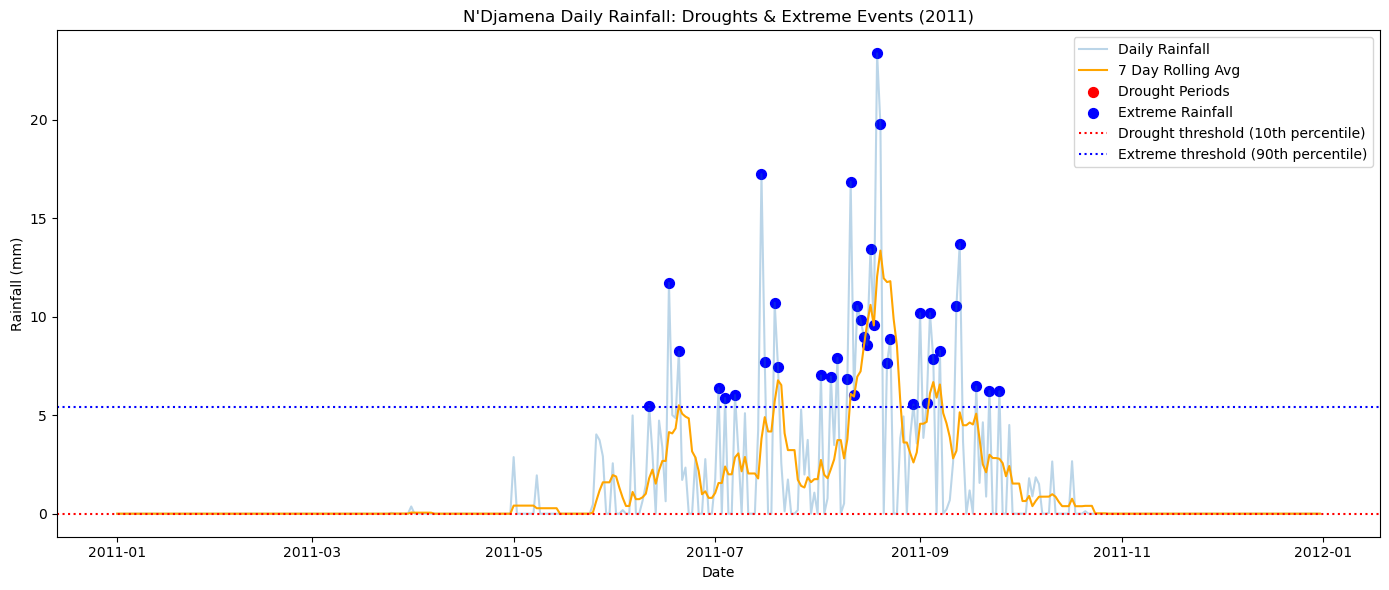

In [9]:
plt.figure(figsize=(14,6))

plt.plot(dataframe_ndjamena["time"], dataframe_ndjamena["precip"], alpha=0.3, label="Daily Rainfall")
plt.plot(dataframe_ndjamena["time"], dataframe_ndjamena["rainfall_7day_avg"], color="orange", label="7 Day Rolling Avg")

plt.scatter(
    dataframe_ndjamena.loc[dataframe_ndjamena["is_drought"], "time"],
    dataframe_ndjamena.loc[dataframe_ndjamena["is_drought"], "rainfall_7day_avg"],
    color = "red",
    label = "Drought Periods",
    s = 50
)

plt.scatter(
    dataframe_ndjamena.loc[dataframe_ndjamena["is_extreme"], "time"],
    dataframe_ndjamena.loc[dataframe_ndjamena["is_extreme"], "precip"],
    color = "blue",
    label = "Extreme Rainfall",
    s = 50
)

plt.axhline(drought_threshold, linestyle=":", color="red", label="Drought threshold (10th percentile)")
plt.axhline(extreme_threshold, linestyle=":", color="blue", label="Extreme threshold (90th percentile)")

plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.title("N'Djamena Daily Rainfall: Droughts & Extreme Events (2011)")
plt.legend()
plt.tight_layout()
plt.show()

## Summary Statistics of N'Djamena

I calculate the number and proportion of:

- **Drought days**  
- **Extreme rainfall days**

This quantifies the frequency of these events in N'Djamena over the year 2011.

In [10]:
num_drought_days = dataframe_ndjamena["is_drought"].sum()
num_extreme_days = dataframe_ndjamena["is_extreme"].sum()
total_days = len(dataframe_ndjamena)

print(f"Drought days: {num_drought_days} ({num_drought_days/total_days*100:.1f}% of year)")
print(f"Extreme rainfall days: {num_extreme_days} ({num_extreme_days/total_days*100:.1f}% of year)")


Drought days: 0 (0.0% of year)
Extreme rainfall days: 37 (10.1% of year)


## Extending Analysis to the Entire Country

While the N'Djamena analysis illustrates the workflow for a single location, it has some limitations:

- N'Djamena is semi arid, so most of the year has zero rainfall. Using a percentile based method over the full year does not flag any drought days.  
- In semi arid climates, sustained periods of 0 mm rainfall should be considered drought by default.

For the **entire country**, additional challenges arise:

- Northern Chad is desert and has almost no rainfall year-round.  
- Averaging across all grid cells would bias the analysis toward the desert climate, hiding meaningful droughts in more humid areas.

To address this, I compute **drought and extreme rainfall thresholds per grid cell**, rather than using a country wide average. This allows me to:

- Detect droughts meaningfully across all regions, including areas that normally receive rainfall.  
- Identify extreme rainfall events relative to the local climate.  

Below, I apply this approach to the CHIRPS data for the entire country, using **7 day rolling averages per grid cell for drought detection** and **daily precipitation per grid cell for extreme rainfall events**. On top of this, when it comes to droughts I will specifically check for consecutive days where **rainfall < 1mm**.


In [11]:
dataframe_chad = chad.to_dataframe().reset_index()
dataframe_chad = dataframe_chad.sort_values(by=["latitude", "longitude", "time"])

dataframe_chad["rainfall_7day_avg"] = dataframe_chad.groupby(["latitude", "longitude"])["precip"].transform(lambda x: x.rolling(7, min_periods=1).mean())


### Drought and Extreme Rainfall Thresholds per gridcell

I define thresholds to flag extreme events as so:

- **Drought threshold**: Experiences >= 7 consecutive days with daily rainfall < 1mm  
- **Extreme rainfall threshold**: 90th percentile of daily precipitation.

The reasoning for applying a drought threshold of 7 consecutive days of near 0 rainfall is that it is generally accepted time frame for a semi arid country or region to be experiencing a drought, and as such I applied it to my analysis of Chad.

#### Flagging Drought and Extreme Events

I create boolean columns to mark:

- **`is_drought`** → True if the dry spell length is greater than 7 
- **`is_extreme`** → True if daily precipitation is above the extreme rainfall threshold

In [12]:
daily_threshold = 1.0

dataframe_chad["is_dry"] = dataframe_chad["precip"] < daily_threshold
dataframe_chad["dry_spell_length"] = (
    dataframe_chad.groupby(["latitude", "longitude"])["is_dry"].apply(lambda x: x.groupby((~x).cumsum()).cumsum()).reset_index(level=[0, 1], drop=True)
)
dataframe_chad["is_drought"] = dataframe_chad["dry_spell_length"] >= 7

dataframe_chad["extreme_threshold"] = dataframe_chad.groupby(["latitude", "longitude"])["precip"].transform(lambda x: x.quantile(0.90))
dataframe_chad["is_extreme"] = dataframe_chad["precip"] > dataframe_chad["extreme_threshold"]

### Country-Level Drought and Extreme Rainfall Dynamics

To extend the analysis from a single location to the national scale, drought and extreme rainfall events are aggregated across all grid cells within Chad.

Rather than averaging rainfall over the entire country, thresholds are computed **per grid cell** to account for Chad’s strong climatic gradients:

- Northern regions are predominantly desert and receive little to no rainfall year-round.
- Southern regions experience a distinct wet season and are more sensitive to drought and extreme rainfall.

For each grid cell:
- **Droughts** are identified when the consecutive days of less than 1mm of rainfall is greater than 7.
- **Extreme rainfall events** are identified when daily precipitation exceeds the 90th percentile of that cell’s climatology.

The figure below shows, for each day in 2011:
- The number of grid cells experiencing drought conditions
- The number of grid cells experiencing extreme rainfall

This provides a country-wide perspective on the spatial extent and temporal clustering of extreme events, rather than focusing on isolated locations.

**NOTE**:  
Drought detection at the country scale uses a persistence based definition rather than percentiles.

In arid and semi arid climates, rainfall distributions are dominated by zero values, causing percentile based methods to fail.  
Here, droughts are defined as periods of **at least seven consecutive days with daily rainfall below 1 mm**, computed per grid cell.

This approach captures sustained dry conditions across both semi arid and desert regions of Chad.



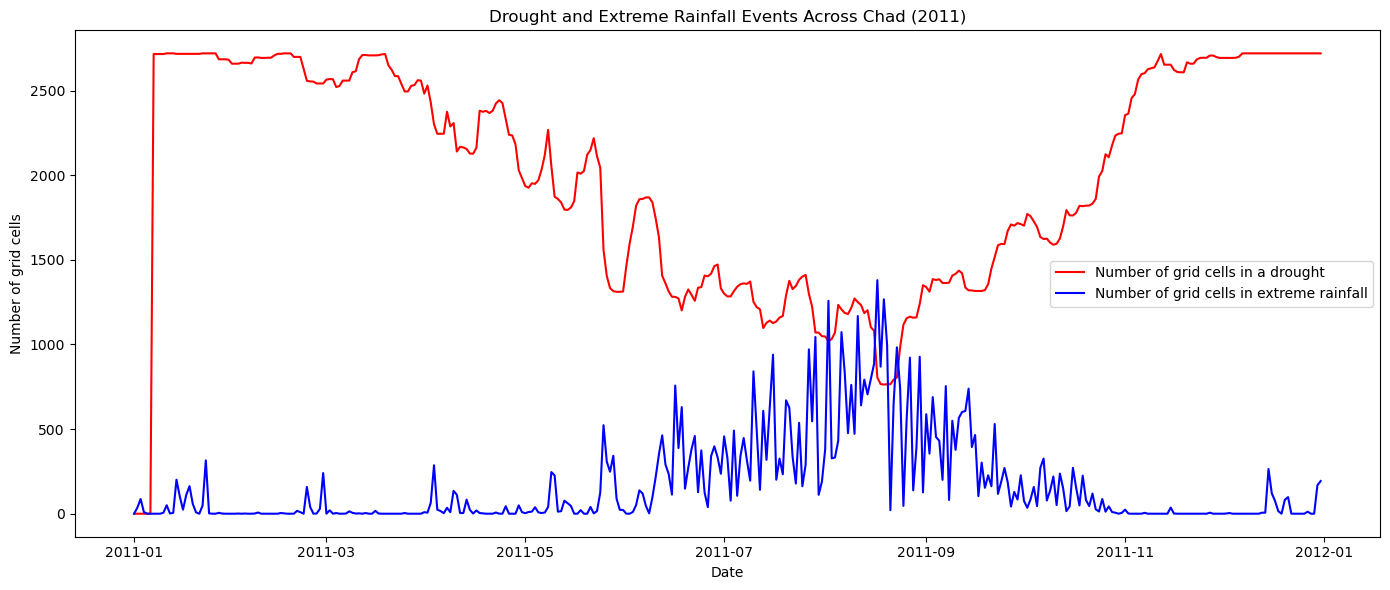

In [13]:
daily_summary = dataframe_chad.groupby("time")[["is_drought", "is_extreme"]].sum().reset_index()

plt.figure(figsize=(14,6))
plt.plot(daily_summary["time"], daily_summary["is_drought"], color="red", label="Number of grid cells in a drought")
plt.plot(daily_summary["time"], daily_summary["is_extreme"], color="blue", label="Number of grid cells in extreme rainfall")

plt.xlabel("Date")
plt.ylabel("Number of grid cells")
plt.title("Drought and Extreme Rainfall Events Across Chad (2011)")
plt.legend()
plt.tight_layout()
plt.show()

### Temporal rainfall behaviour and event identification

The time series analysis shows the highly seasonal nature of rainfall in Chad. Prolonged dry periods are much of the year with a short and intense wet season in the summer where the majority of the rainfall for the year occurs. 

Using percentile based thresholds applied to daily rainfall and rolling averages, extreme rainfall events and drought conditions were identified in the time domain. While this approach is effective for analysing rainfall variability at a single location or as an aggregated signal, it does not show how the rainfall or lack there of is spatially across the country.

To better the geographical pattern of drought in Chad, I will expand the analysis from a temporal perspective to a spatial one. The following section will visualise drought and conditions across Chad for a respective drought day as to examine the wetter parts of the country. This is also important as in semi arid environments nationally aggregated statistics can mask regional variability.

In [14]:
daily_mean_precip = chad["precip"].mean(dim=["latitude", "longitude"])

drought_day_threshold = daily_mean_precip.quantile(0.10)

position = abs(daily_mean_precip - drought_day_threshold).argmin().item()

drought_date = daily_mean_precip["time"].isel(time=position).values
drought_map = chad["precip"].isel(time=position)
drought_mask = drought_map < 1.0

percentile_map = xr.apply_ufunc(
    lambda x, y: (x < y).mean(),
    chad["precip"],
    drought_map,
    input_core_dims=[["time"], []],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
)

percentile_map = percentile_map * 100
percentile_map = percentile_map.rio.write_crs("EPSG:4326")

percentile_clipped = percentile_map.rio.clip(
    chad_shape.geometry,
    chad_shape.crs,
    drop=True
)

bounds = [0, 5, 20, 100]

cmap = colors.ListedColormap(["darkred", "orange", "gold"])
norm = colors.BoundaryNorm(bounds, cmap.N)

### Spatial Distribution of Drought Conditions

To examine how drought conditions appear spatially across Chad, I selected a representative drought day based on national scale rainfall behaviour. Rather than using the absolute lowest rainfall day, as this would result in a uniformly dry map, I selected based off a percentile approach.

I specifically selected the day corresponding to the 10th percentile of spatially averaged rainfall, providing a realistic look at severe conditions of dry season while showing some spatial variety.

The way in which the categories will be assessed by colour goes as so:  
- **Red** sub 5% percentile rainfall  
- **Orange** 5%-20% percentile rainfall  
- **Yellow** over 20% percentile rainfall

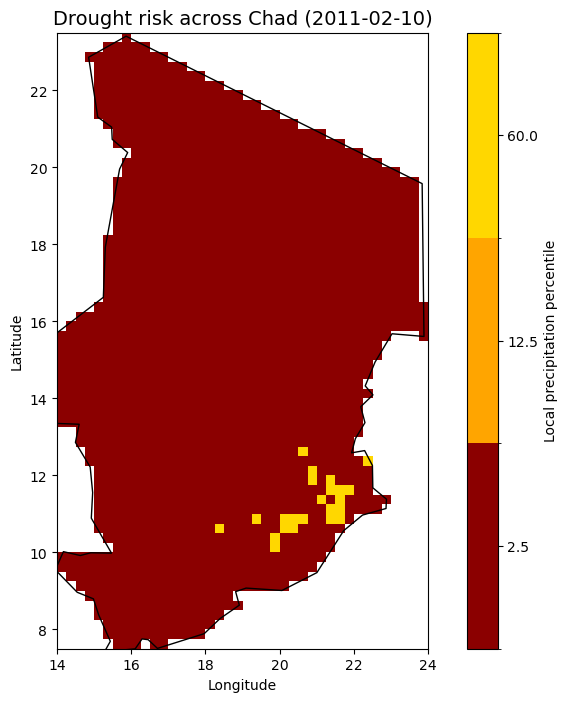

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))

percentile_clipped.plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    cbar_kwargs={
        "label": "Local precipitation percentile",
        "ticks": [2.5, 12.5, 60]
    }
)

chad_shape.boundary.plot(ax=ax, color="black", linewidth=1)

ax.set_title(
    f"Drought risk across Chad ({np.datetime_as_string(drought_date, unit='D')})",
    fontsize=14
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

### Interpretation

The resulting map shows that the majority of Chad experienced extreme drought conditions on this representative day, with most locations falling below the 5th percentile of their local historical precipitation distribution. This spatially coherent drought pattern is consistent with Chad’s predominantly arid climate and the seasonal dominance of dry conditions.

Despite the widespread dryness, localized areas particularly in the southeastern part of the country exhibit higher percentile values, indicating isolated convective rainfall events. This highlights the importance of using relative, location specific metrics when assessing drought risk, as absolute precipitation values alone would obscure meaningful spatial contrasts in climatologically dry regions.

Overall, this approach demonstrates how percentile based normalization allows drought risk to be assessed consistently across regions with strong climatic gradients.

While drought is a dominant climate problem in Chad, the varyingly short wet season can also produce extreme rainfall that poses risks related to flooding, agricultural losses, and infrastructure damage. To provide a more complete picture of the climate risk, the same spatial framework is applied to visualise extreme rainfall during the wet season.

In [16]:
wet_day_threshold = daily_mean_precip.quantile(0.90)

position_wet = abs(daily_mean_precip - wet_day_threshold).argmin().item()

wet_date = daily_mean_precip["time"].isel(time=position_wet).values
wet_map = chad["precip"].isel(time=position_wet)

wet_percentile_map = xr.apply_ufunc(
    lambda x, y: (x < y).mean(),
    chad["precip"],
    wet_map,
    input_core_dims=[["time"], []],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
)

wet_percentile_map = wet_percentile_map * 100
wet_percentile_map = wet_percentile_map.rio.write_crs("EPSG:4326")

wet_percentile_clipped = wet_percentile_map.rio.clip(
    chad_shape.geometry,
    chad_shape.crs,
    drop=True
)

bounds = [0, 80, 95, 100]

cmap = colors.ListedColormap([
    "#adcae5", 
    "#6baed6",  
    "#08306b", 
])
norm = colors.BoundaryNorm(bounds, cmap.N)

### Spatial Distribution of Extreme Rainfall Events

To examine how extreme rain conditions appear spatially across Chad, I selected a representative extreme rain day based on national scale rainfall behaviour. While I could have selected the most wet day in the wet season, I approach it by doing the same method of the drought spatial analysis and selected the 90% percentile of extreme rain.

The way in which the categories will be assessed by colour goes as so:

- **Dark Blue** over 95% percentile rainfall
- **Light Blue** 80%-95% percentile rainfall
- **Very Light Blue** under 80% percentile rainfall

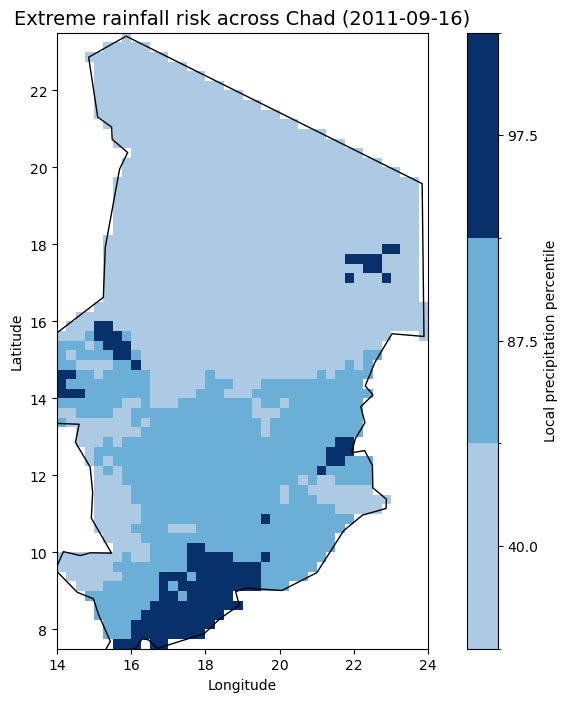

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))

wet_percentile_clipped.plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    cbar_kwargs={
        "label": "Local precipitation percentile",
        "ticks": [40, 87.5, 97.5]
    }
)

chad_shape.boundary.plot(ax=ax, color="black", linewidth=1)

ax.set_title(
    f"Extreme rainfall risk across Chad "
    f"({np.datetime_as_string(wet_date, unit='D')})",
    fontsize=14
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

### Interpretation

The extreme rainfall risk map reveals strong spatial heterogeneity across Chad. Much greater percentiles are concentrated in primarily the southern Sahelian and tropical environments in the south and south east, reflecting the influence of the West African monsoon during the wet season. Despite this there are pockets of heavy rain even in the Sahelian and Saharan parts of Chad, primarily around N'Djamena and Fada.

In contrast, northern and the majority of the Sahelian region exhibit lower percentile values, indicating that even during the wet season rainfall extremes remain geographically consistent. This spatial pattern highlights the clime risk in Chad while the majority of the country is persistently in drought conditions, localised areas experience extreme rainfall events with potentially severe impacts.

Together with the drought analysis, these results demonstrate the value of percentile based, spatially explicit approaches for assessing climate risk in semi arid environments.

## Seasonal Patterns

The analysis presented in this notebook demonstrates that climate risk in Chad is a highly dependent on not only temporal but also spacial scale. At a national level, total annual rainfall is normal within the historical baseline period observed in 1981-2009, supposing that conditions were near normal in 2011. However, upon closer review, this aggregation masks important seasonal and regional parts of the climate in Chad, and that drought is not as one dimensional in a semi arid country like it. This emphasises that while yes, total annual rainfall is normal compared to the historical baseline period, that actually there is a significant climatological reason for the serious agricultural and food security reasons.

Rainfall in Chad is naturally seasonal, with the majority of the rainfall occurring in the timeframe of June-September for the Sahel or May-October in the tropical south. When the analysis is subsetted to just this agriculturally significant period, rainfall deficits emerge as incredibly significant in 2011, with it being one well below the 10th percentile compared to the baseline period. This indicates that the timing of when it rains is incredibly significant in the possibility of drought in Chad, and that it is not tied to the amount of total annual rainfall in the entire country. This highlights the importance of heterogeneity in drought assessment, particularly in semi arid environments where the total annual rainfall does not describe a full picture.

Overall, these results show that drought risk in Chad is best viewed through a seasonal and spatial lense, rather than through annual or national data alone. The combination of a severely dry wet season and regional concentration of rainfall provides a climatological coherent analysis as to why Chad in 2011 sufferred as it did.

## Summary Statistics

The summary statistics consolidate the key findings of the analysis and highlight the scale dependent nature of climate risk in Chad. While national annual rainfall in 2011 appears near normal relative to the historical baseline, wet season rainfall in the Sahel falls among the most severe deficits on record. Together with frequent extreme rainfall events at local scales, these results emphasize that climate impacts in Chad are driven by seasonal timing and regional variability rather than by annual totals alone.

In [18]:
dry_year_percentage = (dry_count20 / total_year) * 100

summary_stats = pd.DataFrame({
    "Metric": [
        "Annual rainfall (national, mm)",
        "Wet season rainfall (Sahel, mm)",
        "Wet season 10th percentile (Sahel)",
        "Wet season percentile (Sahel)",
        "Dry years (1981–2009)",
        "N'Djamena drought days (2011)",
        "N'Djamena extreme rainfall days (2011)"
    ],
    "Baseline": [
        f"{clim_mean:.1f} ± {clim_std:.1f}",
        f"{wet_mean:.1f} ± {wet_std:.1f}",
        f"{wp10:.1f}",
        "-",
        f"{dry_year_percentage:.1f}% ({dry_count20}/{total_year})",
        "-",
        "-"
    ],
    "2011": [
        f"{total_2011:.1f}",
        f"{wetsn_2011:.1f}",
        "-",
        f"{wet_percentile_2011:.1f}%",
        "-",
        f"{num_drought_days} (percentile method limitation)",
        f"{num_extreme_days} ({num_extreme_days/total_days*100:.1f}%)"
    ]
})

summary_stats

,Metric,Baseline,2011
0,"Annual rainfall (national, mm)",358.4 ± 39.2,364.6
1,"Wet season rainfall (Sahel, mm)",426.6 ± 70.4,301.0
2,Wet season 10th percentile (Sahel),350.8,-
3,Wet season percentile (Sahel),-,3.4%
4,Dry years (1981–2009),20.7% (6/29),-
5,N'Djamena drought days (2011),-,0 (percentile method limitation)
6,N'Djamena extreme rainfall days (2011),-,37 (10.1%)


## Summary and Next Steps

This analysis combined temporal and spatial methods to analyse drought and extreme rainfall risk across Chad and its capital using a percentile framework. By using rainfall conditions relative to local climatology, both dry and wet extremes were identified in a way that is robust across regions of different climates.

The results show the coexistence of two opposite risks, highlighting the importance of spatial approaches when assessing climate risk in semi arid regions. The comparison of 2011 with the historic baseline further shows how the climate risk was in 2011 versus the historical rainfall and drought in both the wet season and overall. Upon further analysis of specifically the wet season it shows how 2011 was not simply a problem of generalised lack of rainfall in the year, but rather a seriously low amount of rainfall during the normal wet season in the Sahel of June to September.

Future work will extend this framework to additional regions with contrasting climatic regimes, enabling comparative analysis of drought and extreme rainfall patterns across different parts of the world.